# Vesuvius working with zarr tutorial

This notebook will go through how to load in and interact with a multi-resolution zarr array
For more details you can read the docs: https://zarr.readthedocs.io

If you want to run the cells and 'follow along', follow the below steps. Or you can simply inspect the code and outputs below instead.

Step 0: Download  a .zarr file using the download_zarr_s1.py (~1TB) or download_zarr_s2.py (2.14 TB) files in the Vesuvius Data Download repo if you want to run the notebook and follow along. Or you can just inspect the outputs without running the notebook cells. You could also use the scroll2zarr repo's scroll_to_ome.py file available here: https://github.com/KhartesViewer/scroll2zarr to create a smaller zarr directory from any volumes or masked volumes you have downloaded.

Step 1: run ```pip install zarr numpy matplotlib``` in your python environment and add it as the kernel for this jupyter notebook.<br>
imagecodecs may also be required if working with lzw compressed masked volumes, but it should not be as the .zarr files are not compressed

In [15]:
import zarr #https://zarr.readthedocs.io/en/stable/tutorial.html#tutorial
import matplotlib.pyplot as plt
import time
import numpy as np

#path to zarr file
zarr_path ="/Volumes/16TB_RAID_0/Scroll1/Scroll1.zarr"
Scroll_multi_res_zarr = zarr.open(zarr_path, mode='r')
print(Scroll_multi_res_zarr.info)

Name        : /
Type        : zarr.hierarchy.Group
Read-only   : True
Store type  : zarr.storage.DirectoryStore
No. members : 6
No. arrays  : 6
No. groups  : 0
Arrays      : 0, 1, 2, 3, 4, 5



In [16]:
# For convenience, we'll assign the full resolution version of the zarr to a variable called z, and the 4th reduced resolution version to a variable called z4 (1/8th resolution)
z = Scroll_multi_res_zarr[0] #z is the full resolution version of the zarr, [1] is 1/2 res, [2] is 1/4 res, etc. Because the data is 3d, a 1/2 res reductions is a 8x data size decrease
z4 = Scroll_multi_res_zarr[3] #forth low res version of the zarr for faster iteration

# Print information about the Zarr array
# Note that the No.Bytes assumes all chunks are present in the zarr file,
# Since these zarrs were produced from the masked volumes, many chunks are empty 
# and thus not stored in the zarr file, reducing size. If you index into the empty chunks,
# a blank chunk will be returned.
print(z.info)
print(z4.info)

Name               : /0
Type               : zarr.core.Array
Data type          : uint16
Shape              : (14376, 7888, 8096)
Chunk shape        : (128, 128, 128)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1836138602496 (1.7T)
No. bytes stored   : 22817 (22.3K)
Storage ratio      : 80472393.5
Chunks initialized : 112/448384

Name               : /3
Type               : zarr.core.Array
Data type          : uint16
Shape              : (1797, 986, 1012)
Chunk shape        : (128, 128, 128)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 3586208208 (3.3G)
No. bytes stored   : 8479 (8.3K)
Storage ratio      : 422951.8
Chunks initialized : 14/960



Time to load full z slice:  1.1787607669830322


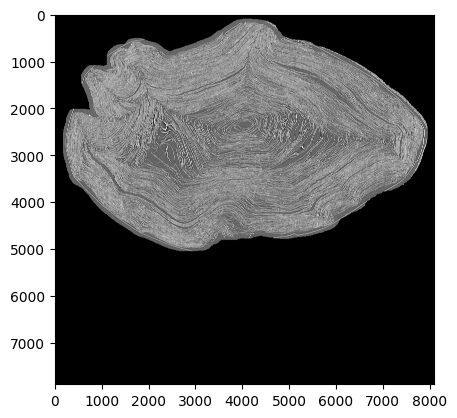

In [17]:
#load a full z slice
# It has to load all the 3d chunks that make up the slice, 
# so chunk size, or 128x more data than a single 2d slice
# Thus it is realtively slow, but unnecessary for most operations
# If you need to view a full z slice, it is better to use the low res version of the zarr
start_time = time.time()
slice = z[1000]
print("Time to load full z slice: ", time.time()-start_time)
plt.imshow(slice, cmap='gray')
plt.show()

Time to load full z slice from 1/8th res:  0.027671098709106445


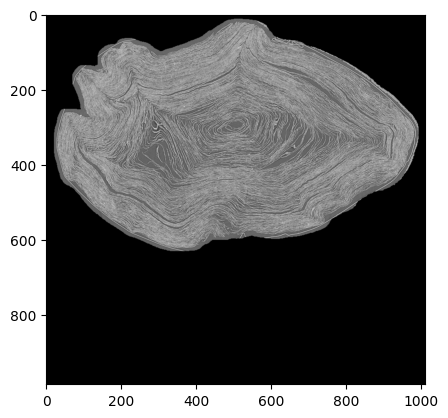

In [18]:
# load full z slice from the 1/8th res version, 
# still across many chunks but much faster as less data
# is needed to load it. Very similar output to the full res version
# for visulisation purposes. Khartes is displaying a low res versions of a zarr
# to the user when zoomed out and then displaying a small part of the full res 
# version when zoomed in this gives near real time full scroll visulisation capabilities
start_time = time.time()
slice = z4[int(1000/8)]
print("Time to load full z slice from 1/8th res: ", time.time()-start_time)
plt.imshow(slice, cmap='gray')
plt.show()

Time to load 3d block:  0.0055119991302490234
(128, 128, 128)


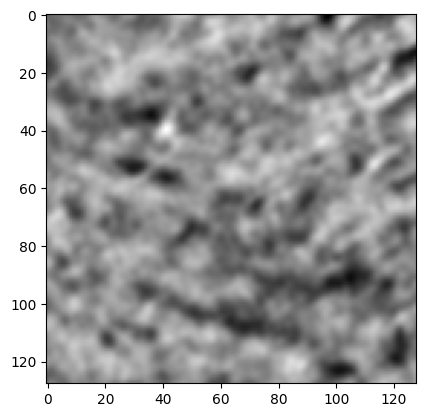

In [19]:
# load an aligned 3d chunk/block from the full res version
# this is faster than loading a slice as it only has to load a single chunk
# this would be ~128x faster than loading a chunk like this from the volume slices
# as it only has to load a single 3d chunk instead of 128 full slices
# For autosegmentation and other operations that require local 3d context, this is the best way to load data
start_time = time.time()
block = z.blocks[10,10,10]
print("Time to load 3d block: ", time.time()-start_time)
print(block.shape)
plt.imshow(block[0], cmap='gray')

Time to load block: 0.0031099319458007812
(128, 128, 128)


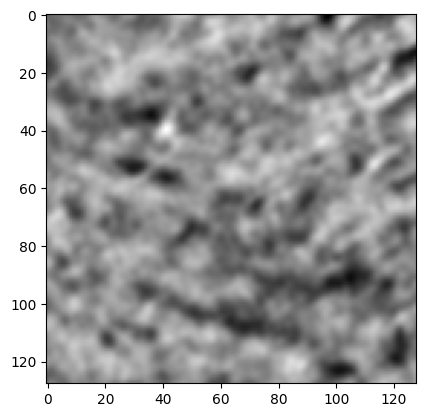

In [20]:
#the above is equivalent to the following:
#the .blocks method is just a convenience method to get aligned blocks
#but you can also get a block by slicing the 3d zarr array, including across chunks
chunk_size = 128
start_time = time.time()
block = z[1280:1280+chunk_size, 1280:1280+chunk_size, 1280:1280+chunk_size]
print("Time to load block:", time.time()-start_time)
print(block.shape)
plt.imshow(block[0], cmap='gray')

In [21]:
# Timing experiment of loading a chunk with .blocks vs slicing
# They are essentially equivalent, with perhaps a slight overhead for the .blocks method 
block_time = 0
slice_time = 0
for i in range(10000):
    block_to_load = i % 40
    start_time = time.time()
    block = z.blocks[block_to_load,block_to_load,block_to_load]
    block_time += time.time()-start_time
    slice_block = block_to_load*128
    start_time = time.time()
    block = z[slice_block:slice_block+chunk_size, slice_block:slice_block+chunk_size, slice_block:slice_block+chunk_size]
    slice_time += time.time()-start_time
print("Average time to load block:", block_time/10000)
print("Average time to load block with slicing:", slice_time/10000)

Average time to load block: 0.000674036431312561
Average time to load block with slicing: 0.0005794047117233277


Time to load 3d block:  0.09000802040100098
(512, 512, 512)


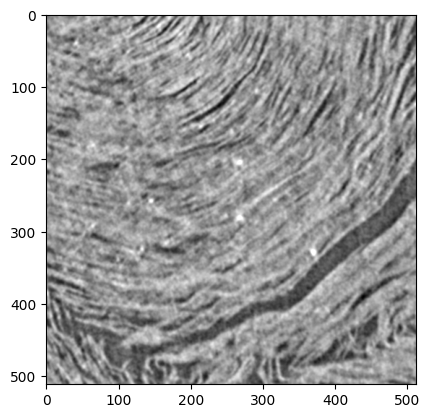

In [22]:
#you can also load multiple aligned 3d chunks/blocks from the full res version
start_time = time.time()
block = z.blocks[10:14,10:14,10:14]
print("Time to load 3d block: ", time.time()-start_time)
print(block.shape)
plt.imshow(block[0], cmap='gray')

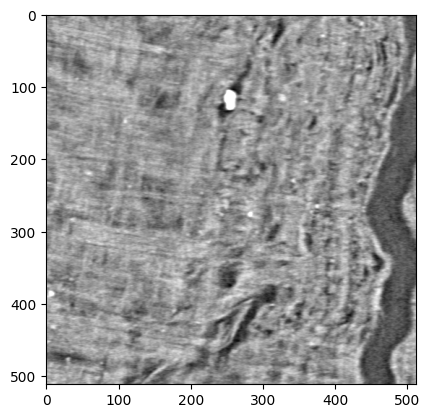

In [36]:
#You can also easily slice a block on the y axis and display
plt.imshow(block[:,225,:], cmap='gray')

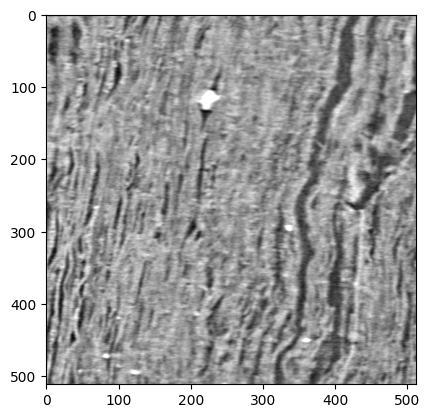

In [35]:
#Or the y axis
plt.imshow(block[:,:,250], cmap='gray')

In [25]:
# You can use this function to display the x,y,z sliced faces of a 3d block
# This is useful for visualising the 3d context of a block
# The color scheme and axis labels are set up to match those in Khartes (hopefully)
def display_faces(index_z, index_x, index_y, vol_grid):
    fig, axs = plt.subplots(1, 3, figsize=(8, 12))

    # Display the z-axis of the volume grid
    axs[0].imshow(vol_grid[index_z], cmap='gray')
    axs[0].axhline(y=index_y, color='blue')
    axs[0].axvline(x=index_x, color='red')
    axs[0].spines['left'].set_color('green')
    axs[0].spines['right'].set_color('green')
    axs[0].spines['top'].set_color('green')
    axs[0].spines['bottom'].set_color('green')
    axs[0].set_xlabel('X-axis')
    axs[0].set_ylabel('Y-axis')
    axs[0].set_title('Z-axis', color='green')

    # Display the x-axis cut of the volume grid
    axs[1].imshow(np.rot90(np.flip(vol_grid[:, :, index_x], axis=1)), cmap='gray')  # Mirror and rotate 90 degrees
    axs[1].axhline(y=index_y, color='blue')
    axs[1].axvline(x=index_z, color='green')
    axs[1].spines['left'].set_color('red')
    axs[1].spines['right'].set_color('red')
    axs[1].spines['top'].set_color('red')
    axs[1].spines['bottom'].set_color('red')
    axs[1].set_xlabel('Z-axis')
    axs[1].set_ylabel('Y-axis')
    axs[1].set_title('X-axis', color='red')

    # Display the y-axis cut of the volume grid
    axs[2].imshow(vol_grid[:, index_y, :], cmap='gray')
    axs[2].axhline(y=index_z, color='green')
    axs[2].axvline(x=index_x, color='red')
    axs[2].spines['left'].set_color('blue')
    axs[2].spines['right'].set_color('blue')
    axs[2].spines['top'].set_color('blue')
    axs[2].spines['bottom'].set_color('blue')
    axs[2].set_xlabel('X-axis')
    axs[2].set_ylabel('Z-axis')
    axs[2].set_title('Y-axis', color='blue')

    plt.tight_layout()
    plt.show()

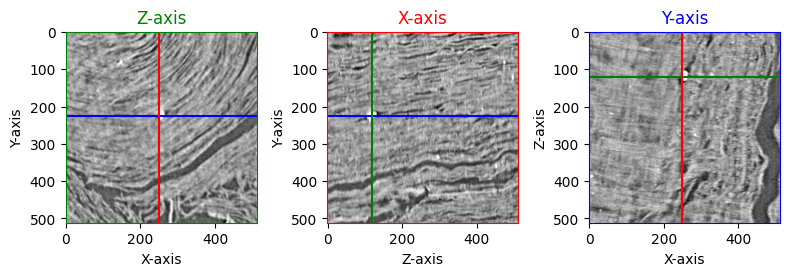

In [34]:
#display the z,x,y faces of a block
display_faces(120, 250, 225, block)